In [1]:
import pickle
import random
import gymnasium
import gymnasium.spaces
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium.envs.registration import register

import csv
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split


register(
    id='AppEnvironment-v0',
    entry_point='RLSimulation:AppEnvironment',
)

In [2]:
def generate_happiness_score(readingtime, activitytime, screentime, default = True):
        model_default = pickle.load(open('modelh_default.pkl', 'rb')) if default else pickle.load(open('modelh_indiv.pkl', 'rb'))
        df = pd.DataFrame({'screentime':[screentime], 'activitytime':[activitytime], 'readingtime':[readingtime]})
        res = model_default.predict(df).astype(int)[0]
        return max(1, min(100,res)) # Make a prediction

        

In [3]:
def create_indiv_dataset(ideal_reading_time, ideal_physical_activity):

    if ideal_reading_time == 0:
        ideal_reading_time = 0.1
    if ideal_physical_activity == 0:
        ideal_physical_activity = 0.1

    ideal_screen_time = 2.0
    screenW = 0.4
    data = []

    for i in range(100000):
        
        day = random.randint(1, 28)
        month = random.randint(1, 12)
        year = 2023
        date_str = f"{year}-{month:02d}-{day:02d}"

        #Generate random inputs in hours
        screen_time = round(random.uniform(0, 5), 1)
        physical_activity = round(random.uniform(0, 5), 1)
        reading_time = round(random.uniform(0, 5), 1)

        # Normalize the time inputs between 0 and 1 
        normalized_screen_time = min(1, max(0, 1 - (screen_time / ideal_screen_time)))
        normalized_physical_activity_default = min(1, physical_activity / ideal_physical_activity)
        normalized_reading_time_default = min(1, reading_time / ideal_reading_time)
        score_default = (screenW * normalized_screen_time) + (0.5 * normalized_physical_activity_default) + (0.5 * normalized_reading_time_default)
        happiness_score_default = max(1, min(100, int(score_default*100) + round(random.uniform(-2, 2),0)))
        data.append([date_str, screen_time, physical_activity, reading_time, happiness_score_default])
    

    with open('dummyh_indiv.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['date', 'screentime', 'activitytime', 'readingtime', 'hscore'])
        writer.writerows(data)



In [4]:
def train_hmodel():
    users = pd.read_csv('dummyh_indiv.csv')
    y = users['hscore']
    users.drop(columns='hscore', inplace=True)
    x = users[['screentime', 'activitytime', 'readingtime']]

    # Training the model
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    model = MLPRegressor(hidden_layer_sizes=(10, 5), max_iter=1000, learning_rate_init=0.01, n_iter_no_change=100, tol=1e-4, verbose=True)
    model.fit(x_train, y_train)
    print(model.score(x_test, y_test))

    pickle.dump(model, open('modelh_indiv.pkl', 'wb'))

In [5]:
class AppEnvironment(gymnasium.Env):
    assessment = True

    def __init__(self):
        self.observation_space = gymnasium.spaces.Box(low=0, high=100, shape=(5,), dtype=float)
        #['readingtime', 'activitytime', 'screentime', 'self reported happiness']
        self.observation = np.array([0.0, 0.0, 5.0, 0.0, float(generate_happiness_score(0, 0, 5))])
        self.action_space = gymnasium.spaces.Discrete(10)
        #['increase_reading', 'increase_activity', 'increase_screentime', 'decrease_reading', 'decrease_activity', 'decrease_screentime', 'self reported happiness 0', 'self reported happiness 1', 'self reported happinness 2', 'self reported happiness 3']

    
    def reset(self, seed=None):
        super().reset()
        self.observation = np.array([0.0, 0.0, 5.0,0.0, float(generate_happiness_score(0, 0, 5))])
        return self.observation, {}

    def step(self, action):
        # Update the state based on the action
        new_obersevation = self.observation.copy()
        done = False
        reward = 0

        #print("Action: ", action, "Obersevation: ", new_obersevation)

        if action == 0:
            new_obersevation[0] += 0.5
        elif action == 1:
            new_obersevation[1] += 0.5
        elif action == 2:
            new_obersevation[2] += 0.5
        elif action == 3:
            new_obersevation[0] -= 0.5
        elif action == 4:
            new_obersevation[1] -= 0.5
        elif action == 5:
            new_obersevation[2] -= 0.5
        elif action == 6:
            new_obersevation[3] = 1
        elif action == 7:
            new_obersevation[3] = 2
        elif action == 8:
            new_obersevation[3] = 3
        elif action == 9:
            new_obersevation[3] = 4
        
        #print("New obersevation: ", new_obersevation)


        if new_obersevation[0] < 0 or new_obersevation[1] < 0 or new_obersevation[2] < 0:
            #print("Negative values")
            reward -= 1000
            new_obersevation = [max(0,x) for x in new_obersevation]

        
        if sum(new_obersevation[0:3]) > 24:
            #print("Sum of all activities is greater than 24")
            reward -= 1000

        if sum(new_obersevation[0:3]) <= 24:
            self.observation = new_obersevation

        new_happiness = generate_happiness_score(self.observation[0], self.observation[1], self.observation[2], self.assessment)
        new_happiness = 0.75 * new_happiness + 0.25 * 25 * self.observation[3]
        reward = new_happiness - self.observation[4]
        
        #do not make big changes in happiness
        if reward >= 20:
            reward -= 10
        
        self.observation[4] = new_happiness

        if new_happiness > 95:
            done = True
            #print("Happiness is greater than 95")
            reward += 100

        #print("Action: ", action, "Obersevation: ", self.observation, "Reward: ", reward, "Done: ", done)

        info = {}
        return self.observation, reward, done, info, {}

In [6]:
assessment_environment = AppEnvironment()
individual_environment = AppEnvironment()
individual_environment.assessment = False


def train_default_RL_model():
    model = PPO('MlpPolicy', env=assessment_environment, learning_rate=0.0001)
    model.learn(total_timesteps=10000, progress_bar=True)
    return model

def train_individual_RL_model():
    model = PPO('MlpPolicy', env=individual_environment, learning_rate=0.0001)
    model.learn(total_timesteps=10000, progress_bar=True)
    return model

## Simulating the Environment

In [7]:
happiness_score=[]
eval_env = AppEnvironment()

mean_finish_time_diff = 0

for i in range(1):

    tmp_arr = []
    obs = eval_env.reset()

    ## assesment period
    assesment_reading_time = 0
    assesment_activity_time = 0

    random_reading_time = round(random.random(),1)
    random_activity_time = round(random.random(),1)

    eval_env.observation = np.array([random_reading_time, random_activity_time, 5.0, 0, float(generate_happiness_score(0, 0, 5))])

    for j in range(10):

        action = random.randint(0,4)

        obs, rewards, dones, _, _ = eval_env.step(action)
        #print("Observation: ", obs)
        tmp_arr.append(obs[4])
        assesment_reading_time += obs[0]
        assesment_activity_time += obs[1]
        if dones:
            print("Episode finished after {} timesteps".format(j+1))
            break
    

    if dones:
        continue
    
    assesment_reading_time /=10
    assesment_activity_time /=10

    assesment_reading_time = round(assesment_reading_time,1)
    assesment_activity_time = round(assesment_activity_time,1)


    print("Finished assesment period, reading time: ", assesment_reading_time, "activity time: ", assesment_activity_time)
    create_indiv_dataset(assesment_reading_time, assesment_activity_time)
    print("Dataset created")
    train_hmodel()
    print("Happinness Model trained")
    general_model = train_default_RL_model()
    print("General RL model trained")
    eval_env.assessment = False
    indiv_model = train_individual_RL_model()
    print("Individual RL model trained")
    
    tmp_arr_general = tmp_arr.copy()
    tmp_obs = obs.copy()
    
    
    ## with individual model ##

    for j in range(100):
        # BestSuggestions
        action, _states = indiv_model.predict(obs)

        # Child will sometimes consider suggestions of app or not
        action = random.randint(2,4) if random.random() < 0.25 else action

        obs, rewards, dones, info, _ = eval_env.step(action)
        print("Observation: ", obs)
        tmp_arr.append(obs[4])
        if dones:
            print("Episode finished after {} timesteps".format(j+1))
            mean_finish_time_diff += j+1
            break
    happiness_score.append(tmp_arr)

    ## with general model ##

    eval_env.reset()
    eval_env.observation = tmp_obs
    eval_env.assessment = True
    for j in range(100):
        # Best Suggestions
        action, _states = general_model.predict(obs)

        # Child will sometimes consider suggestions of app or not
        action = random.randint(2,4) if random.random() < 0.25 else action

        obs, rewards, dones, info,_ = eval_env.step(action)
        print("Observation: ", obs)
        tmp_arr_general.append(obs[4])
        if dones:
            print("Episode finished after {} timesteps".format(j+1))
            mean_finish_time_diff -= j+1
            break
    happiness_score.append(tmp_arr_general)

print("Mean finish time difference: ", mean_finish_time_diff/100)
    


Finished assesment period, reading time:  1.8 activity time:  0.3
Dataset created
Iteration 1, loss = 799.11771915
Iteration 2, loss = 54.83652228
Iteration 3, loss = 27.04992298
Iteration 4, loss = 22.11363247
Iteration 5, loss = 21.55189032
Iteration 6, loss = 21.31949183
Iteration 7, loss = 21.37473666
Iteration 8, loss = 21.24494399
Iteration 9, loss = 21.21080385
Iteration 10, loss = 21.22829942
Iteration 11, loss = 21.19357865
Iteration 12, loss = 21.20664222
Iteration 13, loss = 21.39576221
Iteration 14, loss = 21.28839584
Iteration 15, loss = 21.32514522
Iteration 16, loss = 21.20789743
Iteration 17, loss = 21.23986031
Iteration 18, loss = 21.18973541
Iteration 19, loss = 21.31772505
Iteration 20, loss = 21.14020332
Iteration 21, loss = 21.19310847
Iteration 22, loss = 21.20775063
Iteration 23, loss = 21.34380669
Iteration 24, loss = 21.15615591
Iteration 25, loss = 21.28549502
Iteration 26, loss = 21.22792825
Iteration 27, loss = 21.23493093
Iteration 28, loss = 21.21481137
It

/home/andrei/ETH/wunderkind/WunderkindBackend/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Output()

Output()

General RL model trained


Individual RL model trained
Observation:  [2.7, 1.0, 5.0, 0, 74.25]
Observation:  [2.2, 1.0, 5.0, 0, 74.25]
Observation:  [2.7, 1.0, 5.0, 0, 74.25]
Observation:  [2.7, 1.5, 5.0, 0, 74.25]
Observation:  [2.2, 1.5, 5.0, 0, 74.25]
Observation:  [1.7000000000000002, 1.5, 5.0, 0, 72.75]
Observation:  [1.7000000000000002, 1.5, 5.0, 4, 97.75]
Episode finished after 7 timesteps
Observation:  [2.2, 1.0, 5.0, 2, 77.75]
Observation:  [2.2, 1.0, 4.5, 2, 76.25]
Observation:  [2.2, 0.5, 4.5, 2, 65.75]
Observation:  [2.2, 1.0, 4.5, 2, 76.25]
Observation:  [2.2, 1.5, 4.5, 2, 87.5]
Observation:  [2.2, 1.5, 5.0, 2, 87.5]
Observation:  [2.2, 1.5, 5.5, 2, 87.5]
Observation:  [1.7000000000000002, 1.5, 5.5, 2, 82.25]
Observation:  [1.7000000000000002, 1.5, 5.0, 2, 83.75]
Observation:  [2.2, 1.5, 5.0, 2, 87.5]
Observation:  [2.2, 1.5, 4.5, 2, 87.5]
Observation:  [2.2, 1.5, 5.0, 2, 87.5]
Observation:  [2.2, 2.0, 5.0, 2, 87.5]
Observation:  [2.2, 2.0, 4.5, 2, 87.5]
Observation:  [2.2, 2.0, 4.5, 4, 100.0]
Episo

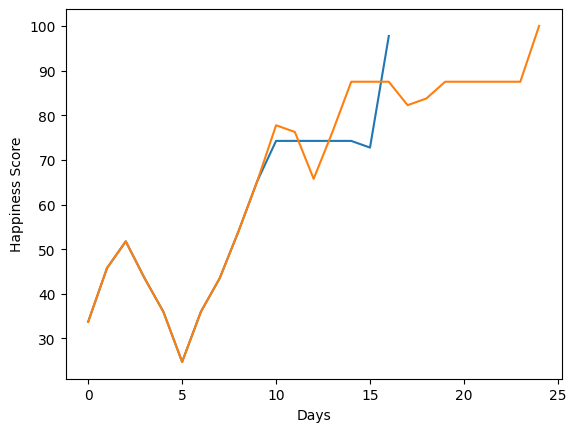

In [8]:
for i in range(2):
    plt.plot(happiness_score[i])
plt.ylabel('Happiness Score')
plt.xlabel('Days')
plt.show()
